# Learning API

This guide covers the Learning API, which provides endpoints for training and inference with RxInfer models. You'll learn how to create, manage, and interact with episodes as well as perform a simple learning task.

## Prerequisites

Before using the Models API, you need to initialize the RxInfer client. The client will automatically handle authentication for you.

In [1]:
from rxinferclient import RxInferClient
import numpy as np
import matplotlib.pyplot as plt

# Initialize the client
client = RxInferClient()

## Historical Dataset

For this demonstration, we'll work with a synthetic dataset that represents a two-dimensional dynamical system. The data is generated by rotating a two-dimensional vector around the origin, creating a circular motion pattern. The dataset consists of:

- Hidden states: The true positions in 2D space
- Observations: Noisy measurements of these positions
- Training and test sets: The data is split to evaluate the model's predictive performance

In [33]:
def generate_rotate_ssm_data(n, k, split=0.8, seed=42):
    np.random.seed(seed)
    theta = np.pi / k
    A = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    Q = np.eye(2)
    P = np.eye(2)
    
    x_prev = np.ones(2)
    x = np.zeros((n, 2))
    y = np.zeros((n, 2))

    for i in range(n):
        x[i] = np.random.multivariate_normal(A @ x_prev, Q)
        y[i] = np.random.multivariate_normal(x[i], P)
        x_prev = x[i]

    split_idx = int(n * split)
    x_train = x[:split_idx]
    y_train = y[:split_idx]
    x_test = x[split_idx:]
    y_test = y[split_idx:]

    return x_train, y_train, x_test, y_test

def plot_dimension(x_train, y_train, x_test, y_test, dimension):
    train_indices = np.arange(len(y_train))
    test_indices = np.arange(len(y_train), len(y_train) + len(y_test))
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_indices, x_train[:, dimension], label="states (training set)", linewidth=2)
    plt.scatter(train_indices, y_train[:, dimension], label="observations (training set)", s=4)
    plt.plot(test_indices, x_test[:, dimension], label="states (test set)", linewidth=2)
    plt.scatter(test_indices, y_test[:, dimension], label="observations (test set)", s=4)
    plt.legend(loc='lower left')
    return plt.gcf()

def load_dataset():
    x_train, y_train, x_test, y_test = generate_rotate_ssm_data(400, 8)
    return {"x_train": x_train, "y_train": y_train, "x_test": x_test, "y_test": y_test}

def plot_dataset(dataset):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
    
    # Plot first dimension
    train_indices = np.arange(len(dataset["y_train"]))
    test_indices = np.arange(len(dataset["y_train"]), len(dataset["y_train"]) + len(dataset["y_test"]))
    
    ax1.plot(train_indices, dataset["x_train"][:, 0], label="states (training set)", linewidth=2)
    ax1.scatter(train_indices, dataset["y_train"][:, 0], label="observations (training set)", s=20, alpha=0.7)
    ax1.plot(test_indices, dataset["x_test"][:, 0], label="states (test set)", linewidth=2)
    ax1.scatter(test_indices, dataset["y_test"][:, 0], label="observations (test set)", s=20, alpha=0.7)
    ax1.legend(loc='lower left')
    
    # Plot second dimension
    ax2.plot(train_indices, dataset["x_train"][:, 1], label="states (training set)", linewidth=2)
    ax2.scatter(train_indices, dataset["y_train"][:, 1], label="observations (training set)", s=20, alpha=0.7)
    ax2.plot(test_indices, dataset["x_test"][:, 1], label="states (test set)", linewidth=2)
    ax2.scatter(test_indices, dataset["y_test"][:, 1], label="observations (test set)", s=20, alpha=0.7)
    ax2.legend(loc='lower left')
    
    return fig

The visualization below shows both the true states and their corresponding noisy observations for both training and test periods.

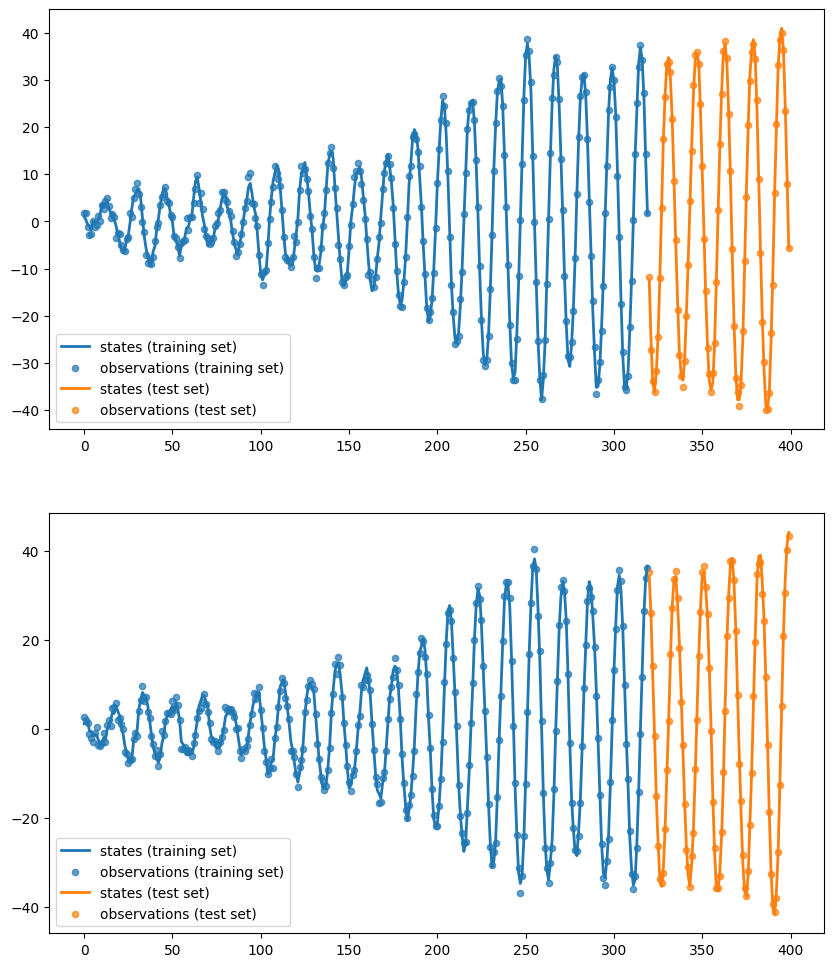

In [34]:
dataset = load_dataset()
fig = plot_dataset(dataset)
plt.show()

## Creating a Model Instance 

To analyze this dataset, we'll use the `LinearStateSpaceModel-v1`, which is designed to learn and predict the dynamics of linear state-space systems. 
This model is particularly suitable for our rotating signal as it can capture the underlying circular motion pattern.

In [35]:
response = client.models.create_model_instance({
    "model_name": "LinearStateSpaceModel-v1",
    "description": "Example model for demonstration",
    "arguments": {
        "state_dimension": 2,
        "horizon": len(dataset["x_test"])
    }
})
instance_id = response.instance_id

## Working with Episodes

Episodes serve as containers for organizing training data and metadata in your model. They provide a structured way to:

- Manage different _episodes_ of interacting with the environment
- Store sequential observations and arbitrary metadata attached to each event
- Track experiments and perform learning
- Organize model validation

### Listing Episodes

To view all episodes associated with a model instance, use the `get_episodes` endpoint. This provides an overview of all available training sessions and their current status.

!!! note 
    Each model automatically creates a `default` episode when it is created.

In [36]:
response = client.models.get_episodes(instance_id)
print(response)

[EpisodeInfo(instance_id='3e18b929-d3fe-4025-89c8-8d8eb0ccfdd0', episode_name='default', created_at=datetime.datetime(2025, 4, 9, 13, 4, 9, 935000, tzinfo=TzInfo(+02:00)), events=[])]


### Episode Details

For detailed information about a specific episode, including its events and metadata, use the `get_episode_info` endpoint. This is particularly useful when analyzing training history or debugging model behavior.

In [37]:
response = client.models.get_episode_info(instance_id, "default")
print(response)

instance_id='3e18b929-d3fe-4025-89c8-8d8eb0ccfdd0' episode_name='default' created_at=datetime.datetime(2025, 4, 9, 13, 4, 9, 935000, tzinfo=TzInfo(+02:00)) events=[]


As we can see, the `default` episode has no events since we haven't loaded any data into it yet nor run any inference.

### Creating New Episodes

When you want to start a new training session or experiment, create a new episode using the `create_episode` endpoint. 

In [38]:
response = client.models.create_episode(instance_id, {
    "name": "experiment-1"
})
print(response)

instance_id='3e18b929-d3fe-4025-89c8-8d8eb0ccfdd0' episode_name='experiment-1' created_at=datetime.datetime(2025, 4, 9, 13, 4, 11, 163000, tzinfo=TzInfo(+02:00)) events=[]


To confirm the new episode has been added to the list:

In [39]:
response = client.models.get_episodes(instance_id)
print(response)

[EpisodeInfo(instance_id='3e18b929-d3fe-4025-89c8-8d8eb0ccfdd0', episode_name='default', created_at=datetime.datetime(2025, 4, 9, 13, 4, 9, 935000, tzinfo=TzInfo(+02:00)), events=[]), EpisodeInfo(instance_id='3e18b929-d3fe-4025-89c8-8d8eb0ccfdd0', episode_name='experiment-1', created_at=datetime.datetime(2025, 4, 9, 13, 4, 11, 163000, tzinfo=TzInfo(+02:00)), events=[])]


## Loading External Data into an Episode

The `attach_events_to_episode` endpoint allows you to load historical data into episodes for training or analysis. This is essential when you have pre-collected data that you want to use for model training or evaluation.

Each event in your dataset should include:
- `data`: The actual observation or measurement data (required)
- `timestamp`: The time when the event occurred (optional, defaults to current time)
- `metadata`: Additional contextual information about the event (optional)

In [40]:
# Create events with data
events = [{"data": {"observation": y.tolist()}} for y in dataset["y_train"]]

# Attach events to an episode
response = client.models.attach_events_to_episode(instance_id, "experiment-1", {
    "events": events
})
print(response)

message='Events attached to the episode successfully'


To verify that your data was loaded correctly:

In [41]:
response = client.models.get_episode_info(instance_id, "experiment-1")
print(response.events[:5])  # show only the first 5 events

[{'data': {'observation': [1.685598791258122, 2.6913285201132173]}, 'id': 1, 'metadata': {}, 'timestamp': '2025-04-09T13:04:12.004'}, {'data': {'observation': [1.8568749376055622, 2.0098560536264465]}, 'id': 2, 'metadata': {}, 'timestamp': '2025-04-09T13:04:12.005'}, {'data': {'observation': [-1.151819784080379, 1.3309346163746762]}, 'id': 3, 'metadata': {}, 'timestamp': '2025-04-09T13:04:12.005'}, {'data': {'observation': [-2.8065098511059823, -1.0791064108480724]}, 'id': 4, 'metadata': {}, 'timestamp': '2025-04-09T13:04:12.005'}, {'data': {'observation': [-2.7223379008367363, -1.989442101566027]}, 'id': 5, 'metadata': {}, 'timestamp': '2025-04-09T13:04:12.005'}]


!!! note "Loading External Data"
    - Events can be loaded into any episode, not just the default one
    - Use `wipe_episode` to clear an episode's data and start fresh
    - Events persist across episode switches
    - Deleting a model instance removes all associated episodes and their data

## Learn the Parameters of the Model

To learn the parameters of the model on the loaded data, create a learning request that specifies which episodes to use for training:

In [42]:
response = client.models.run_learning(instance_id, {
    "episodes": ["experiment-1"]  # learn from the "experiment-1" episode explicitly
})
print(response)

learned_parameters={'A': [0.9237977605471469, 0.9279011733605701]}


The learning process returns a response containing the model's learned parameters. The model's state has been updated automatically with the new parameters. We can verify this by fetching the current model parameters:

In [43]:
response = client.models.get_model_instance_parameters(instance_id)
print(response)

parameters={'A': [0.9237977605471469, 0.9279011733605701]}


After the learning process is complete, we can use the model to make predictions on new data by calling the inference endpoint.

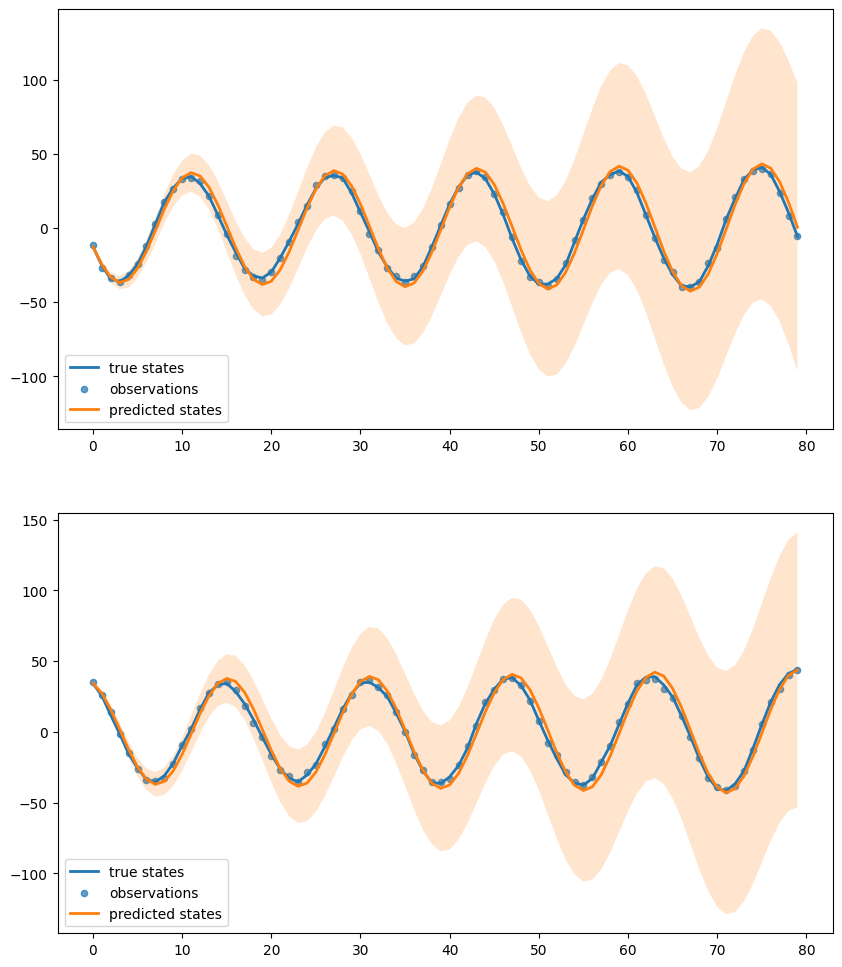

In [44]:
# Set preferences for the inference response format
client._api_client.default_headers["Prefer"] = "distributions_repr=data,distributions_data=mean_cov,mdarray_data=diagonal,mdarray_repr=data"

# Run inference
response = client.models.run_inference(instance_id, {
    "data": {
        "observation": dataset["y_train"][-1].tolist(),
        "current_state": dataset["x_train"][-1].tolist()
    }
})

# Extract and plot the results
states = response.results["states"]
states_mean = [state["mean"] for state in states]
states_cov = [state["cov"] for state in states]

# Plot the results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# First dimension
ax1.plot(dataset["x_test"][:, 0], label="true states", linewidth=2)
ax1.scatter(range(len(dataset["y_test"])), dataset["y_test"][:, 0], label="observations", s=20, alpha=0.7)
ax1.plot([s[0] for s in states_mean], label="predicted states", linewidth=2)
ax1.fill_between(range(len(states_mean)), 
                [s[0] - c[0] for s, c in zip(states_mean, states_cov)],
                [s[0] + c[0] for s, c in zip(states_mean, states_cov)],
                alpha=0.2)
ax1.legend(loc='lower left')

# Second dimension
ax2.plot(dataset["x_test"][:, 1], label="true states", linewidth=2)
ax2.scatter(range(len(dataset["y_test"])), dataset["y_test"][:, 1], label="observations", s=20, alpha=0.7)
ax2.plot([s[1] for s in states_mean], label="predicted states", linewidth=2)
ax2.fill_between(range(len(states_mean)),
                [s[1] - c[1] for s, c in zip(states_mean, states_cov)],
                [s[1] + c[1] for s, c in zip(states_mean, states_cov)],
                alpha=0.2)
ax2.legend(loc='lower left')

plt.show()